In [1]:
import netCDF4 as nc
import os
import numpy as np
import pandas as pd
import pickle
import scipy.io as sio
from scipy.interpolate import interp1d

In [2]:
file_dir = r'../observation'
filename_list = os.listdir(file_dir)
print(filename_list)

['小时平均风向-海威12.xlsx', '小时平均风速-海威13.xlsx', '时数据 10月 温度.csv', '时数据 202310月 降雨.csv', '时数据 20239月降水.csv', '时数据 9月 温度.csv', '时数据202311月 温度.csv', '时数据202311月 降水.csv', '时数据202312月气温.csv', '时数据202312月降水.csv', '时数据202401月气温.csv', '时数据202401月降水.csv', '时数据202402月气温.csv', '时数据202402月降水.csv', '时数据202403月气温.csv', '时数据202403月降水.csv', '时数据202404月气温.csv', '时数据202404月降水.csv', '时数据202405月气温.csv', '时数据202405月降水.csv', '时数据202406月气温.csv', '时数据202406月降水.csv', '时数据202407月气温.csv', '时数据202407月降水.csv', '时数据202408月气温.csv', '时数据202408月降水.csv', '海威1号气象观测站-极大.xlsx', '海威2号气象观测站-极大2.xlsx']


In [3]:
filepath = os.path.join(file_dir, filename_list[2])
df = pd.read_excel(filepath, engine='openpyxl')
df

,时间,风速,风向
0,2023-09-01 00:00:00,9.9,13
1,2023-09-01 01:00:00,9.7,20
2,2023-09-01 02:00:00,9.2,19
3,2023-09-01 03:00:00,7.8,22
4,2023-09-01 04:00:00,7.3,4
...,...,...,...
8035,2024-07-31 19:00:00,9.2,236
8036,2024-07-31 20:00:00,7.9,245
8037,2024-07-31 21:00:00,12.6,218
8038,2024-07-31 22:00:00,13.6,213


In [4]:
time = df['时间']
velocity = df['风速']
degree = df['风向']

In [5]:
time

0      2023-09-01 00:00:00
1      2023-09-01 01:00:00
2      2023-09-01 02:00:00
3      2023-09-01 03:00:00
4      2023-09-01 04:00:00
               ...        
8035   2024-07-31 19:00:00
8036   2024-07-31 20:00:00
8037   2024-07-31 21:00:00
8038   2024-07-31 22:00:00
8039   2024-07-31 23:00:00
Name: 时间, Length: 8040, dtype: datetime64[ns]

In [6]:
velocity

0        9.9
1        9.7
2        9.2
3        7.8
4        7.3
        ... 
8035     9.2
8036     7.9
8037    12.6
8038    13.6
8039    12.4
Name: 风速, Length: 8040, dtype: float64

In [7]:
degree

0        13
1        20
2        19
3        22
4         4
       ... 
8035    236
8036    245
8037    218
8038    213
8039    221
Name: 风向, Length: 8040, dtype: int64

In [8]:
# 检查是否有遗漏的时间并构建时间轴方便后续插值
time_s = time[0]
time_e = time.values[-1]
time_axis = pd.date_range(pd.Timestamp(time_s), pd.Timestamp(time_e), freq='h').to_numpy()
print(time_axis.shape)

(8040,)


## 剔除异常值及梯度的时间一致性检验

In [9]:
# 找出nan值索引
nan_indices = df[velocity.isna()].index
print(nan_indices)
# 找出缺失值索引
null_indices = df[velocity.isnull()].index
print(null_indices)

Index([], dtype='int64')
Index([], dtype='int64')


In [10]:
# 找出nan值索引
nan_indices = df[degree.isna()].index
print(nan_indices)
# 找出缺失值索引
null_indices = df[degree.isnull()].index
print(null_indices)

Index([], dtype='int64')
Index([], dtype='int64')


In [11]:
# # 检查海面风速值是否都在参考经验范围内
# 打印不在范围内的索引
out_of_range_indices = df[(velocity > 75) | (velocity < 0)].index
print(out_of_range_indices)
# df_ = df_.drop(out_of_range_indices, axis=0)
# # 重置索引
# df_ = df_.reset_index(drop=True)
# print(df_)

Index([], dtype='int64')


In [12]:
# 检查风向是否都在[0, 360]之间
# 打印不在范围内的索引
out_of_range_indices = df[(degree > 360) | (degree < 0)].index
print(out_of_range_indices)
df_ = df.drop(out_of_range_indices, axis=0)
# 重置索引
df_ = df_.reset_index(drop=True)

Index([1970, 1971, 1972, 1973, 1974, 1975], dtype='int64')


In [13]:
df.shape

(8040, 3)

In [14]:
df_.shape

(8034, 3)

In [15]:
# 
time_ = df_['时间']
velocity_ = df_['风速']
degree_ = df_['风向']

In [16]:
# 时间一致性检验（梯度）
# 定义函数
def quality_control(data, H):
    # 初始化结果列表，用于存放不满足条件的数据序列
    non_conforming_sequences = []
    # 遍历一维数据及其对应的序列号，检查相邻元素差值
    for i in range(len(data) - 1):
        difference = abs(data[i] - data[i + 1])
        # 如果差值大于阈值，则将序列号加入结果列表
        if difference > H:
            non_conforming_sequences.append(i+1)
    return  non_conforming_sequences
# 设置阈值H
H1 = 20
#
problematic_sequences_velocity = quality_control(velocity, H1)
print(problematic_sequences_velocity)

[]


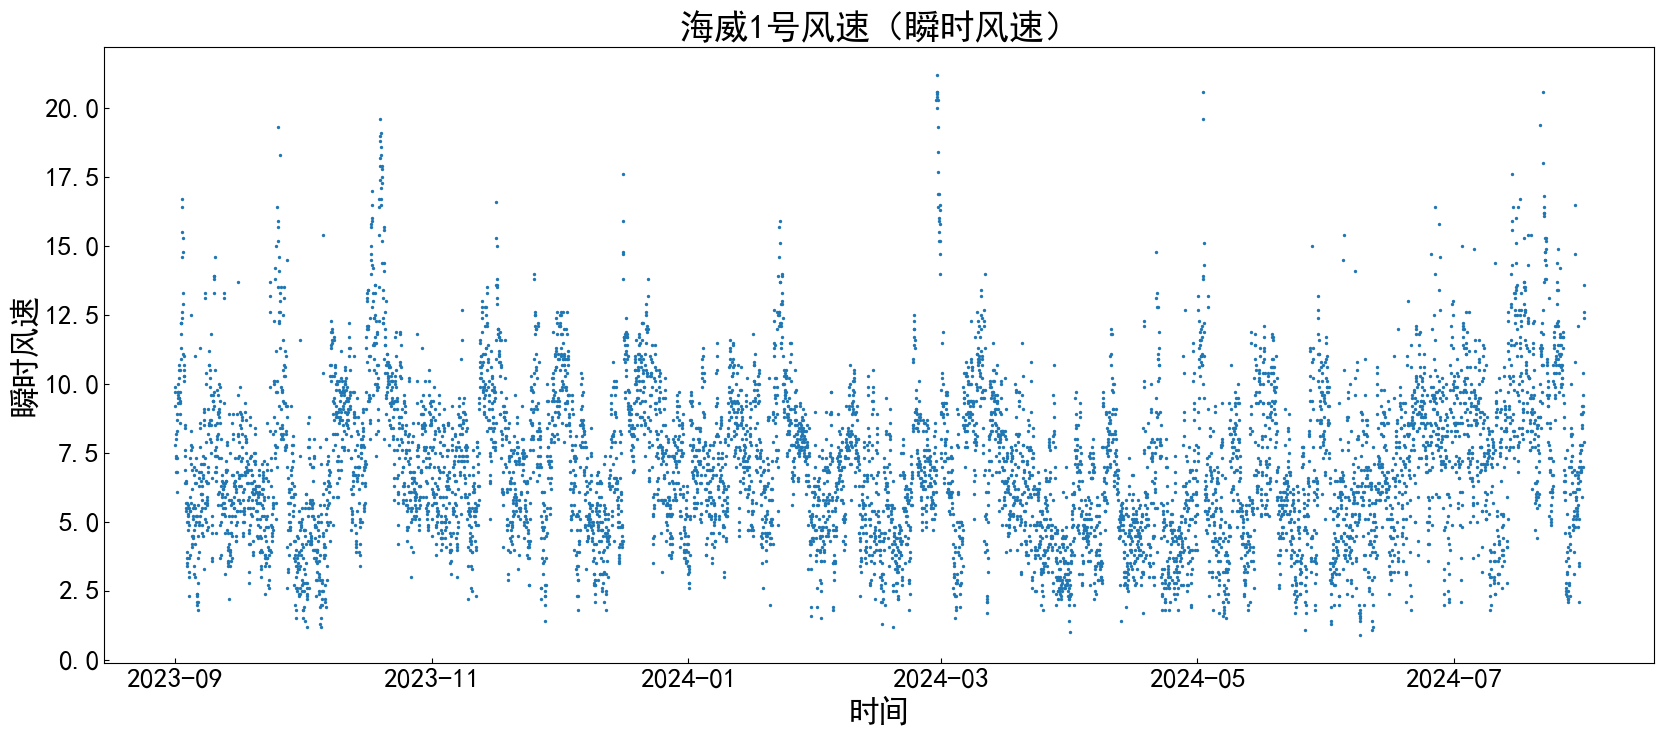

In [17]:
import matplotlib.pyplot as plt
# 设置Matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
size = 2
line_width = 1

plt.figure(figsize=(20, 8))

plt.scatter(time_.values, velocity_, linewidth = line_width, s=size)

plt.tick_params(direction='in', labelsize=20)
plt.xlabel('时间', fontsize=22)
plt.ylabel('瞬时风速', fontsize=22)
# plt.legend(scatterpoints = 5, loc='upper right', fontsize=20)
plt.title('海威1号风速（瞬时风速）', fontsize=25)
plt.savefig('../pic_01/海威1号风速（瞬时风速）', dpi=300, bbox_inches='tight')
plt.show()

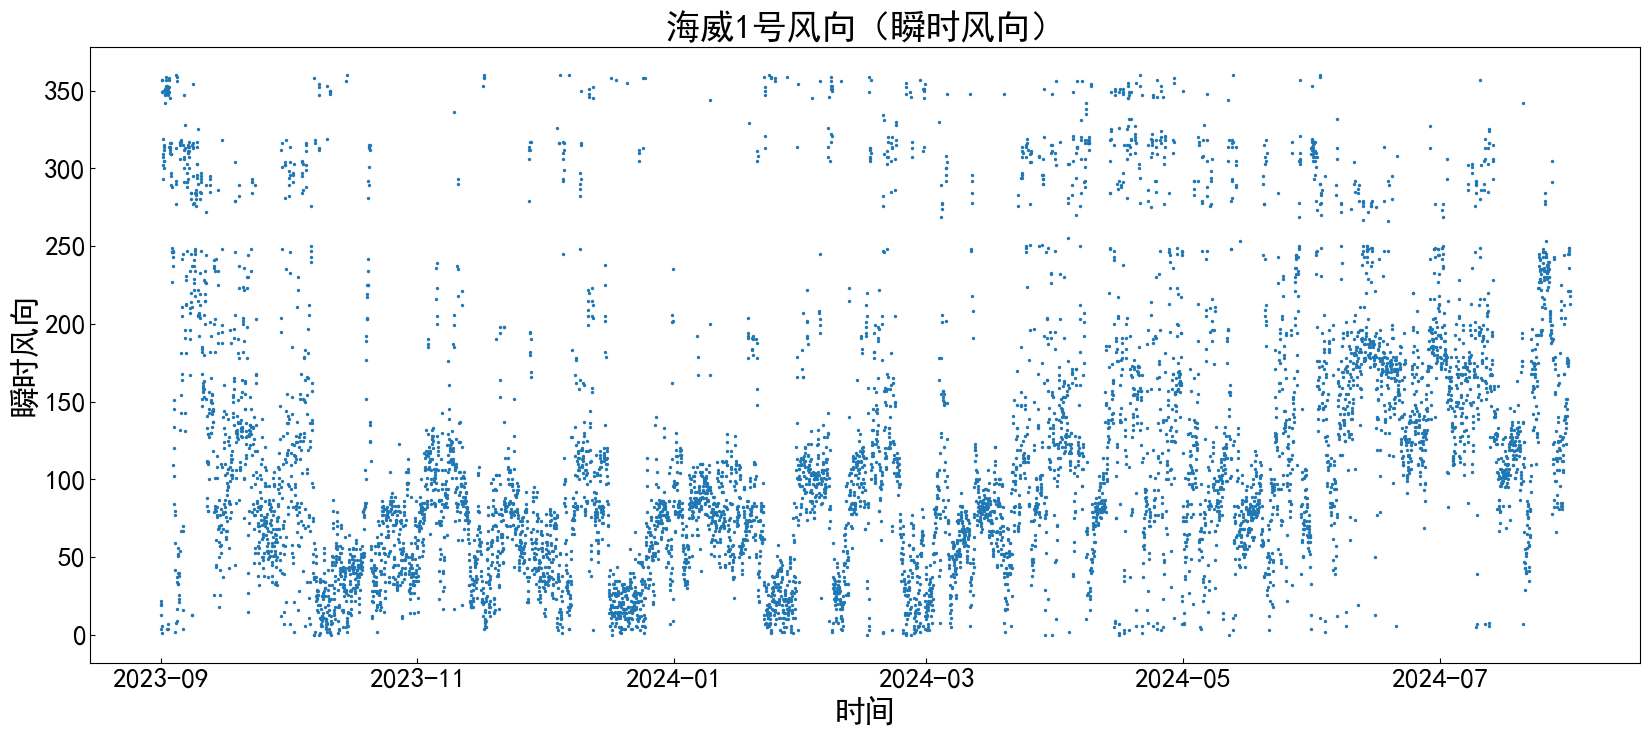

In [18]:
import matplotlib.pyplot as plt
# 设置Matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
size = 2
line_width = 1

plt.figure(figsize=(20, 8))

plt.scatter(time_.values, degree_, linewidth = line_width, s=size)

plt.tick_params(direction='in', labelsize=20)
plt.xlabel('时间', fontsize=22)
plt.ylabel('瞬时风向', fontsize=22)
# plt.legend(scatterpoints = 5, loc='upper right', fontsize=20)
plt.title('海威1号风向（瞬时风向）', fontsize=25)
plt.savefig('../pic_01/海威1号风向（瞬时风向）', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
## 保存时间轴及海威1号风速数据
#
sio.savemat('../data_target_01/observation_axis_init.mat', {'time': time_})
sio.savemat('../data_target_01/observation_variables_init.mat', {'velocity': velocity_, 'degree': degree_})

# 插值到3h

In [20]:
time_.shape

(8034,)

In [21]:
# 构建3h一个的时间轴
start_time = '2023-09-01 00:00:00'
end_time = '2024-07-31 23:00:00'
time_axis_3h = pd.date_range(start=start_time, end=end_time, freq='3h')
# 打印时间轴
print(time_axis_3h)

DatetimeIndex(['2023-09-01 00:00:00', '2023-09-01 03:00:00',
               '2023-09-01 06:00:00', '2023-09-01 09:00:00',
               '2023-09-01 12:00:00', '2023-09-01 15:00:00',
               '2023-09-01 18:00:00', '2023-09-01 21:00:00',
               '2023-09-02 00:00:00', '2023-09-02 03:00:00',
               ...
               '2024-07-30 18:00:00', '2024-07-30 21:00:00',
               '2024-07-31 00:00:00', '2024-07-31 03:00:00',
               '2024-07-31 06:00:00', '2024-07-31 09:00:00',
               '2024-07-31 12:00:00', '2024-07-31 15:00:00',
               '2024-07-31 18:00:00', '2024-07-31 21:00:00'],
              dtype='datetime64[ns]', length=2680, freq='3h')


In [22]:
time_axis_3h.shape

(2680,)

In [23]:
# 将时间转为时间戳格式
time_axis_init = time_.squeeze().astype('int64')

time_axis_3h = time_axis_3h.astype('int64')

In [24]:
time_axis_init

0       1693526400000000000
1       1693530000000000000
2       1693533600000000000
3       1693537200000000000
4       1693540800000000000
               ...         
8029    1722452400000000000
8030    1722456000000000000
8031    1722459600000000000
8032    1722463200000000000
8033    1722466800000000000
Name: 时间, Length: 8034, dtype: int64

In [25]:
time_axis_3h

Index([1693526400000000000, 1693537200000000000, 1693548000000000000,
       1693558800000000000, 1693569600000000000, 1693580400000000000,
       1693591200000000000, 1693602000000000000, 1693612800000000000,
       1693623600000000000,
       ...
       1722362400000000000, 1722373200000000000, 1722384000000000000,
       1722394800000000000, 1722405600000000000, 1722416400000000000,
       1722427200000000000, 1722438000000000000, 1722448800000000000,
       1722459600000000000],
      dtype='int64', length=2680)

In [26]:
interp1d_velocity = interp1d(time_axis_init, velocity_)
interp1d_degree = interp1d(time_axis_init, degree_)

In [27]:
velocity10m = interp1d_velocity(time_axis_3h)
degree10m = interp1d_degree(time_axis_3h)

In [28]:
len(velocity10m)

2680

In [29]:
# 
sio.savemat('../data_target_01/observation_3h.mat', {'time': time_axis_3h ,'velocity': velocity10m, 'degree': degree10m})